## Kunskapskontroll Frida Kilby

1. Importera biblioteken

In [371]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [301]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # when windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # when SQL server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [302]:
# fill up with my data
engine = new_engine('mssql', 'KIWI', 'AdventureWorks2022', integrated_security=True)

mssql://KIWI/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


2. Skapa connection med databasen

In [372]:
# printing engine
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [373]:
# creating connection
connection = engine.connect()

In [374]:
# printing to see that connection is correct
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


3. Min SQL-Query

In [375]:
# Number of Employee per JobTitle
query1= """
SELECT Count(BusinessEntityID) AS 'Antal Anställda', JobTitle FROM HumanResources.Employee
GROUP BY JobTitle;
"""
# Number of Employee per JobTitle to plot
query1_1= """
SELECT top 10 Count(BusinessEntityID) AS NO_Employee, JobTitle FROM HumanResources.Employee
GROUP BY JobTitle
Order by Count(BusinessEntityID) DESC;
"""

# Number of different JobTitle
query2= """
SELECT Count(Distinct JobTitle)  AS 'Antal Jobbtitlar' FROM HumanResources.Employee;
"""

# Number of Employee
query3= """
SELECT Count(BusinessEntityID) AS 'Antal anställda' FROM HumanResources.Employee;
"""

# Average age
query4= """
SELECT 
AVG(DATEDIFF(yy,BirthDate,getdate())) AS 'Medelålder på företaget'
FROM HumanResources.Employee;
"""

# Names of Department
query5= """
SELECT [Name] FROM HumanResources.Department
group by [Name];
"""

# Number of Departments 
query5_1= """
SELECT Count(distinct [Name]) AS 'Antal avdelningar' FROM HumanResources.Department;
"""

# Number of SalesPersons
query6= """
SELECT count(BusinessEntityID) AS 'Antal Säljare'
FROM Person.Person
WHERE PersonType='SP'
Group by PersonType;
"""

# Number of products per color
query7= """
SELECT COUNT(ProductID), [Color]
FROM Production.Product
Group by [Color];
"""

# Number of products that takes more then one day to manifacture
query8= """
SELECT COUNT(ProductID) As 'Antal produkter fler dagar än 1'
FROM Production.Product
Where DaysToManufacture > 1
;
"""

# Total Sales, Tax and Freight
query9= """
SELECT CAST( SUM([SubTotal]) AS INT) As 'total försäljning'
      ,CAST( SUM([TaxAmt]) AS INT) As 'total moms'
      ,CAST( SUM([Freight]) AS INT) AS 'total frakt'
FROM [AdventureWorks2022].[Sales].[SalesOrderHeader];
"""

# Number of Stores they sell products to
query10= """
SELECT Count(BusinessEntityID) AS 'Antal affärer som de säljer varor till'
FROM Sales.Store;
"""

3.2 De lite mer avancerade SQL strängarna för statistiken

In [376]:
# Products with information about margin, name and Subcategory name
long_query1= """
SELECT PP.ProductID
	, PP.[Name]
	, CAST(PP.ListPrice - PP.StandardCost AS INT) AS 'Differens'
	, Count(SOD.OrderQty) AS 'Antal sålda'
	, CAST( (PP.ListPrice - PP.StandardCost) * Count(SOD.OrderQty) AS INT) AS 'Total vinst'
	,PS.[Name] AS 'Produkt Kategori'
FROM Production.Product AS PP
	LEFT JOIN Sales.SalesOrderDetail AS SOD
	ON PP.ProductID = SOD.ProductID
		LEFT JOIN Production.ProductSubcategory AS PS
		ON PP.ProductSubcategoryID = PS.ProductSubcategoryID
GROUP BY PP.ProductID, PP.[Name], PP.ListPrice, PP.StandardCost, PS.[Name]
-- ORDER BY 'Total vinst' DESC ;
-- ORDER BY 'Differens' DESC ;
"""

# Salespersons with full name that haven't sold as much as last year
long_query2="""
-- Med SUBQUERY för att hämta för, mellan och efternamn som en sträng
SELECT CAST( SALES.SalesYTD AS INT) AS 'SaleThisYear'
	, CAST( SALES.SalesLastYear AS INT) AS 'SaleLastYear'
	, CAST( SALES.SalesYTD - SALES.SalesLastYear AS INT) AS LessThenLastYear
	, (SELECT CONCAT_WS(' ', PERSON.FirstName, PERSON.MiddleName, PERSON.LastName) FROM Person.Person
	AS PERSON
		WHERE SALES.BusinessEntityID=PERSON.BusinessEntityID) AS FullName
FROM Sales.SalesPerson AS SALES
WHERE (SALES.SalesYTD - SALES.SalesLastYear) <= 0;
;
"""

# Salespersons with fullname that had no sales last year
long_query3="""
-- Med SUBQUERY för att hämta för, mellan och efternamn som en sträng för de säljare som inte hade några siffror fg år -------------
SELECT CAST( SALES.SalesYTD AS INT) AS 'SaleThisYear'
	, CAST( SALES.SalesLastYear AS INT) AS 'SaleLastYear'
	, CAST (SALES.SalesYTD - SALES.SalesLastYear AS INT) AS BetterThenLastYear
	, (SELECT CONCAT_WS(' ', PERSON.FirstName, PERSON.MiddleName, PERSON.LastName) FROM Person.Person
	AS PERSON
		WHERE SALES.BusinessEntityID=PERSON.BusinessEntityID) AS FullName
FROM Sales.SalesPerson AS SALES
WHERE SALES.SalesLastYear = 0
ORDER BY BetterThenLastYear DESC;
;
"""

# Salespersons with fullname that have sold more then last year
long_query4="""
-- Med SUBQUERY för att hämta för, mellan och efternamn som en sträng för säljare som uppnått fg års siffror och hur mycket mer -------------
SELECT CAST( SALES.SalesYTD AS INT) AS 'SaleThisYear'
	, CAST( SALES.SalesLastYear AS INT) AS 'SaleLastYear'
	, CAST( SALES.SalesYTD - SALES.SalesLastYear AS INT) AS BetterThenLastYear
	, (SELECT CONCAT_WS(' ', PERSON.FirstName, PERSON.MiddleName, PERSON.LastName) FROM Person.Person
	AS PERSON
		WHERE SALES.BusinessEntityID=PERSON.BusinessEntityID) AS FullName
FROM Sales.SalesPerson AS SALES
WHERE (SALES.SalesYTD - SALES.SalesLastYear) >= 0 AND  SALES.SalesLastYear != 0
ORDER BY BetterThenLastYear DESC;
;
"""

3.3 fortsättning av SQL-stängar

In [377]:
# Avergare age and Average year as employee
query11= """
SELECT 
	AVG(DATEDIFF(yy,BirthDate,getdate())) AS AvgAge
	, AVG(DATEDIFF(yy,HireDate,getdate())) AS AvgYearsAsEmployee
 FROM HumanResources.Employee;
 """

# Age and years as employee to coubt average from in python
query11_1="""SELECT 
	DATEDIFF(yy,BirthDate,getdate()) AS Age
	, DATEDIFF(yy,HireDate,getdate()) AS YearsAsEmployee
 FROM HumanResources.Employee;"""

# Most common Jobtitle
query12= """
 SELECT TOP 1 WITH TIES
	count(JobTitle) AS PersonWithTitle, JobTitle
 FROM HumanResources.Employee
 GROUP BY JobTitle
 ORDER By count(JobTitle) DESC;
 """

# MartialStatus of employee
query13= """
SELECT TOP 1
	COUNT(MaritalStatus) AS Gift
	, MaritalStatus = CASE MaritalStatus
		WHEN 'M' THEN 'Married'
		WHEN 'S' THEN 'Single'
		ELSE 'Unknown'
		END
FROM HumanResources.Employee
GROUP BY MaritalStatus
ORDER BY COUNT(MaritalStatus) DESC
;
 """

# Gender of Employee
query14= """
SELECT TOP 1
	COUNT(Gender) NumberOfGender
	, Gender = CASE Gender
		WHEN 'M' THEN 'Male'
		WHEN 'F' THEN 'Female'
		ELSE 'Unknown'
		END
FROM HumanResources.Employee
GROUP BY Gender
ORDER BY COUNT(Gender) DESC
;
 """

# Rate per hour for all employee
query15= """
WITH Rate_CTE (MaxRateChangeDate, BusinessEntityID)
AS
	(
		SELECT MAX(RateChangeDate) as MaxRateChangeDate, BusinessEntityID
		FROM HumanResources.EmployeePayHistory
		GROUP BY BusinessEntityID
	)

SELECT Avg(Rate) AS 'Medellön per timme'
FROM HumanResources.EmployeePayHistory AS HR
WHERE RateChangeDate = (SELECT Rate_CTE.MaxRateChangeDate
						FROM Rate_CTE
						WHERE HR.BusinessEntityID = Rate_CTE.BusinessEntityID
						)
;
"""

3.4 SQL-kod för konfidensintervall

In [378]:
# Query for confidence intervall
query_conf="""
SELECT * FROM Production.WorkOrder;
"""

4. Hämta datan från SQL med hjälp av pandas dataframe

In [379]:
df1 = pd.read_sql(sql=query1, con=connection)
df1_1 = pd.read_sql(sql=query1_1, con=connection)
df2 = pd.read_sql(sql=query2, con=connection)
df3 = pd.read_sql(sql=query3, con=connection)
df4 = pd.read_sql(sql=query4, con=connection)
df5 = pd.read_sql(sql=query5, con=connection)
df5_1 = pd.read_sql(sql=query5_1, con=connection)
df6 = pd.read_sql(sql=query6, con=connection)
df7 = pd.read_sql(sql=query7, con=connection)
df8 = pd.read_sql(sql=query8, con=connection)
df9 = pd.read_sql(sql=query9, con=connection)
df10 = pd.read_sql(sql=query10, con=connection)

df_long1 = pd.read_sql(sql=long_query1, con=connection)
df_long2 = pd.read_sql(sql=long_query2, con=connection)
df_long3 = pd.read_sql(sql=long_query3, con=connection)
df_long4 = pd.read_sql(sql=long_query4, con=connection)

df11 = pd.read_sql(sql=query11, con=connection)
df11_1 = pd.read_sql(sql=query11_1, con=connection)
df12 = pd.read_sql(sql=query12, con=connection)
df13 = pd.read_sql(sql=query13, con=connection)
df14 = pd.read_sql(sql=query14, con=connection)
df15 = pd.read_sql(sql=query15, con=connection)

df_conf= pd.read_sql(sql=query_conf, con=connection)

5. Presentation av data

In [380]:
print(df2)
print(df3)
print(df4)
print(df5_1)
print(df6)
print(df8)
print(df10)
print(df9)

   Antal Jobbtitlar
0                67
   Antal anställda
0              290
   Medelålder på företaget
0                       45
   Antal avdelningar
0                 16
   Antal Säljare
0             17
   Antal produkter fler dagar än 1
0                              104
   Antal affärer som de säljer varor till
0                                     701
   total försäljning  total moms  total frakt
0          109846381    10186974      3183430


In [381]:
# Confidence intervall for size on orders
N_O_orders = df_conf.OrderQty
confint = stats.norm.interval(0.95, loc=np.mean(N_O_orders), scale=stats.sem(N_O_orders))

print(f"Konfidensintervall för antal produkter per order är: {confint}")

Konfidensintervall för antal produkter per order är: (57.118217180899315, 67.07682077146393)


In [382]:
print(df_long1.sort_values("Total vinst", ascending=False).head(10))
print(df_long1.sort_values("Differens", ascending=False).head(10))

     ProductID                     Name  Differens  Antal sålda  Total vinst  \
286        782   Mountain-200 Black, 38       1043         1252      1305847   
287        783   Mountain-200 Black, 42       1043         1177      1227621   
283        779  Mountain-200 Silver, 38       1054         1094      1153481   
285        781  Mountain-200 Silver, 46       1054         1054      1111307   
288        784   Mountain-200 Black, 46       1043         1059      1104546   
284        780  Mountain-200 Silver, 42       1054         1040      1096545   
257        753         Road-150 Red, 56       1407          475       668314   
253        749         Road-150 Red, 62       1407          470       661279   
298        794       Road-250 Black, 48        888          712       632542   
297        793       Road-250 Black, 44        888          705       626323   

    Produkt Kategori  
286   Mountain Bikes  
287   Mountain Bikes  
283   Mountain Bikes  
285   Mountain Bikes  
288 

In [383]:
print(df_long2)

   SaleThisYear  SaleLastYear  LessThenLastYear               FullName
0       1453719       1620277           -166557       Garrett R Vargas
1       1352577       1927059           -574482  Pamela O Ansman-Wolfe
2       1421811       2278549           -856738        Lynn N Tsoflias


In [384]:
print(df_long3)

   SaleThisYear  SaleLastYear  BetterThenLastYear            FullName
0       1576562             0             1576562  Tete A Mensa-Annan
1        559698             0              559698     Stephen Y Jiang
2        519906             0              519906       Amy E Alberts
3        172524             0              172524        Syed E Abbas


In [385]:
print(df_long4)

   SaleThisYear  SaleLastYear  BetterThenLastYear                    FullName
0       4251369       1439156             2812213            Linda C Mitchell
1       4116871       1635823             2481048                   Jae B Pak
2       3763178       1750406             2012772            Michael G Blythe
3       3189418       1997186             1192232              Jillian Carson
4       3121616       2396540              725077  Ranjit R Varkey Chudukatil
5       2604541       2038235              566306        José Edvaldo Saraiva
6       1827067       1307950              519117             Rachel B Valdez
7       2315186       1849641              465545         Tsvi Michael Reiter
8       2458536       2073506              385030                   Shu K Ito
9       1573013       1371635              201378            David R Campbell


In [386]:
print(df11)
print(df12)
print(df13)
print(df14)
print(df15)

   AvgAge  AvgYearsAsEmployee
0      45                  14
   PersonWithTitle                      JobTitle
0               26  Production Technician - WC50
1               26  Production Technician - WC60
2               26  Production Technician - WC40
   Gift MaritalStatus
0   146       Married
   NumberOfGender Gender
0             206   Male
   Medellön per timme
0             18.1882


6. Diagram och andra klurigheter

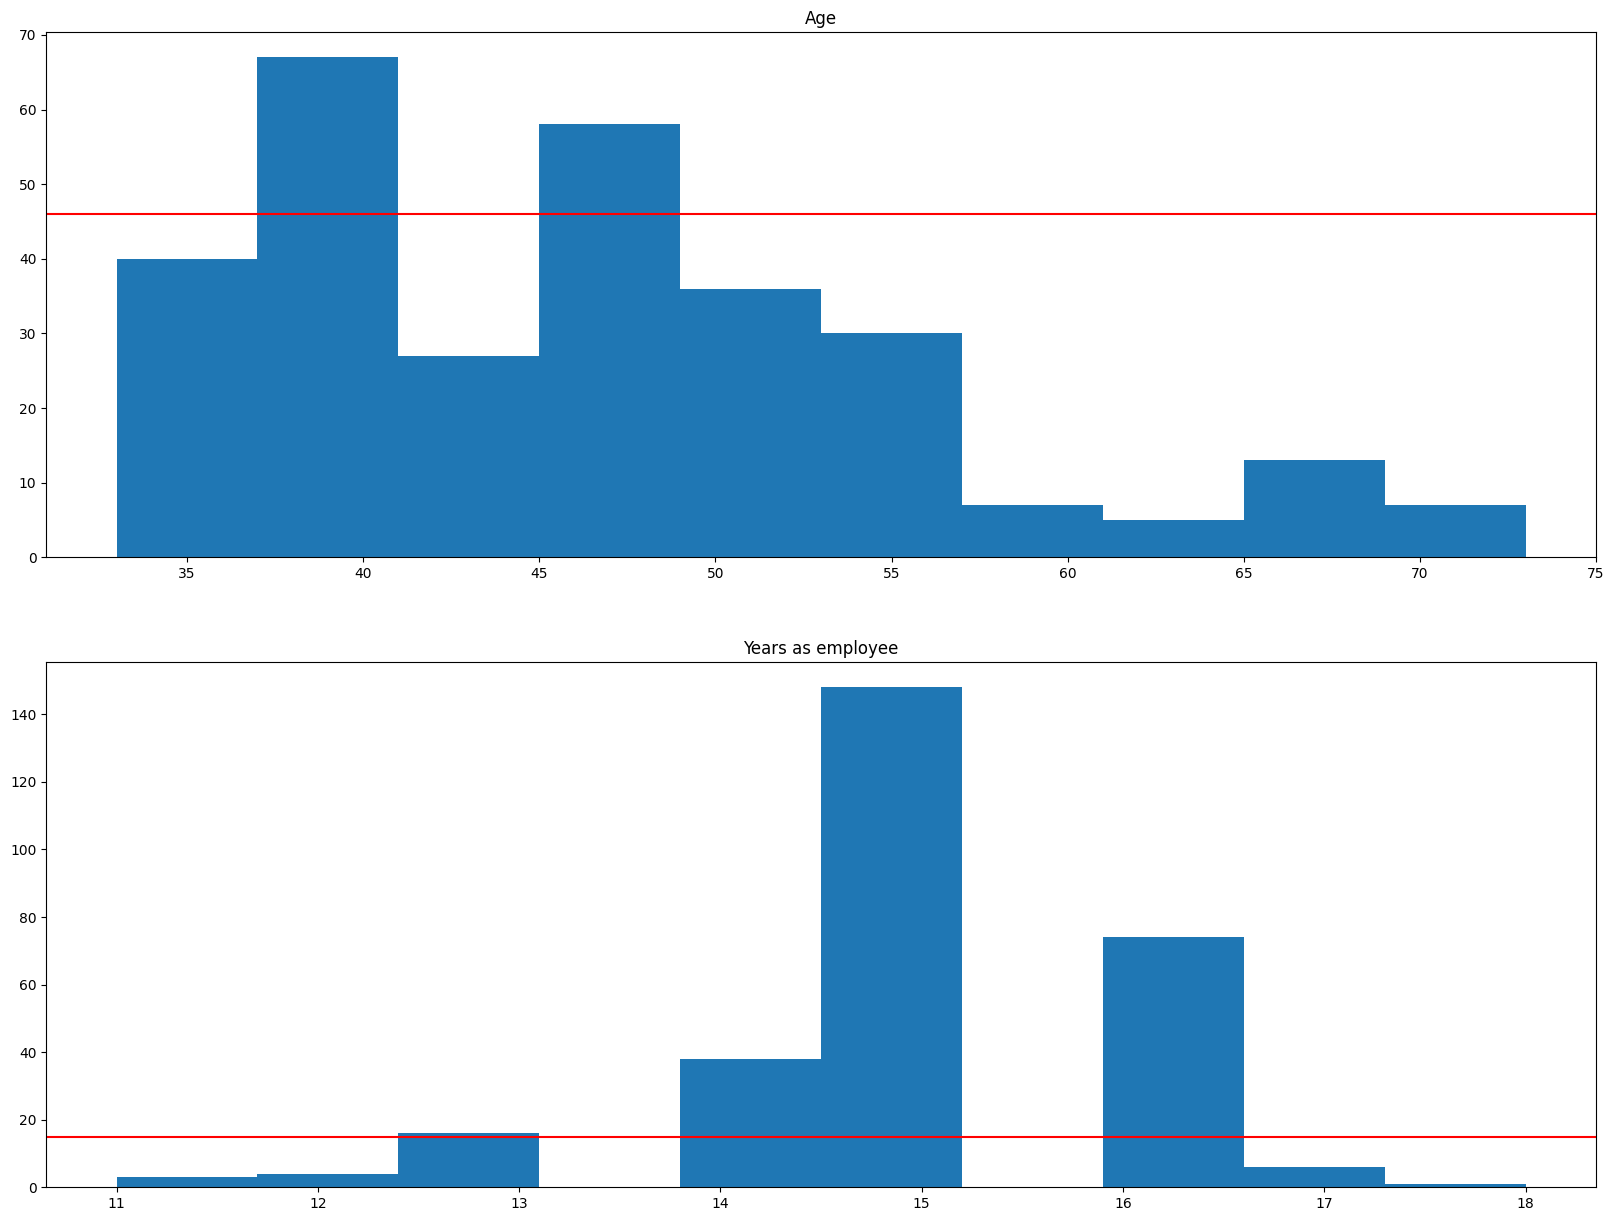

In [387]:
# Figures showing mean for Age and Years as a Employee

fig, axs = plt.subplots(2,1, figsize=(20,15))
axs[0].hist(df11_1.Age)
axs[0].axhline(y=np.mean(df11_1.Age), color='red', label='Avg')
axs[0].set_title('Age')

axs[1].hist(df11_1.YearsAsEmployee)
axs[1].axhline(y=np.mean(df11_1.YearsAsEmployee), color='red', label='Avg')
axs[1].set_title('Years as employee')

plt.show()

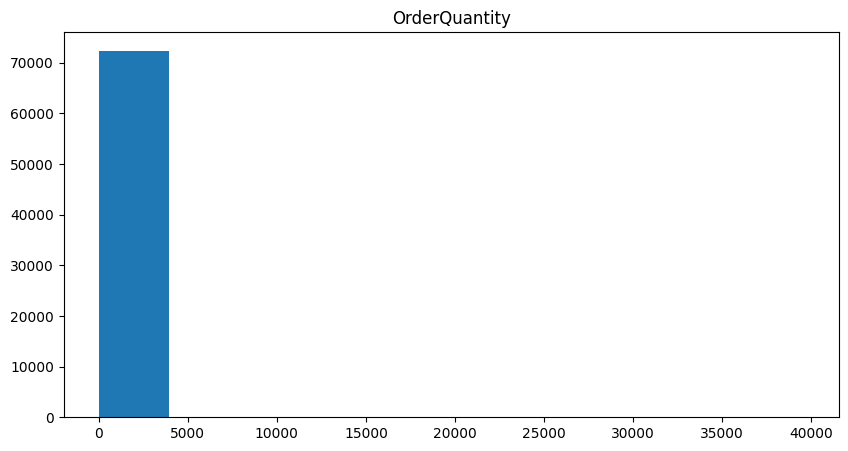

,WorkOrderID,ProductID,OrderQty,StockedQty,ScrappedQty,StartDate,EndDate,DueDate,ScrapReasonID,ModifiedDate
36295,36296,996,1,1,0,2013-05-28,2013-06-08,2013-06-08,NaN,2013-06-08
26372,26373,793,1,1,0,2012-12-08,2012-12-19,2012-12-19,NaN,2012-12-19
26371,26372,792,1,1,0,2012-12-08,2012-12-19,2012-12-19,NaN,2012-12-19
59895,59896,892,1,1,0,2014-02-02,2014-02-12,2014-02-13,NaN,2014-02-12
59897,59898,900,1,1,0,2014-02-02,2014-02-12,2014-02-13,NaN,2014-02-12
...,...,...,...,...,...,...,...,...,...,...
47659,47660,3,33040,33040,0,2013-10-03,2013-10-13,2013-10-14,NaN,2013-10-13
17733,17734,3,33420,33420,0,2012-07-03,2012-07-13,2012-07-14,NaN,2012-07-13
50529,50530,3,34620,34620,0,2013-11-02,2013-11-12,2013-11-13,NaN,2013-11-12
42064,42065,3,39270,39270,0,2013-08-03,2013-08-13,2013-08-14,NaN,2013-08-13


In [388]:
# Trying to make a figure showing OrderQuantity

plt.figure(figsize=(10,5))
plt.hist(df_conf.OrderQty)
plt.title('OrderQuantity')

plt.show()

# Been thinking for a while why I don't get a good diagram of the data, but thats because the smallest OrderQty is one
# and the biggest is over 39000 and there is a lot of the smaller ones.
df_conf.sort_values("OrderQty", ascending=False)
df_conf.sort_values("OrderQty", ascending=True)

   NO_Employee                      JobTitle
0           26  Production Technician - WC40
1           26  Production Technician - WC50
2           26  Production Technician - WC60
3           25  Production Technician - WC30
4           22  Production Technician - WC20
5           17  Production Technician - WC10
6           15  Production Technician - WC45
7           14          Sales Representative
8            9                         Buyer
9            5          Marketing Specialist


<BarContainer object of 10 artists>

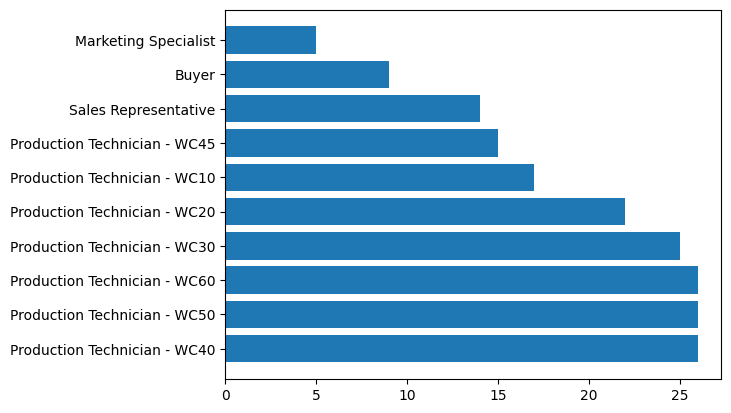

In [389]:
# A plot of most common jobtitles
print(df1_1)
fig, ax = plt.subplots()

ax.barh(df1_1.JobTitle,df1_1.NO_Employee)


In [390]:
print(df_long1.sort_values("Total vinst", ascending=False).head(10))
my_plot = df_long1.groupby(['Produkt Kategori']) ['Total vinst'].sum()
# my_plot = df_long1.groupby(['Produkt Kategori'])
print(my_plot)
# plt.plot(my_plot.head(5))
# plt.show()

     ProductID                     Name  Differens  Antal sålda  Total vinst  \
286        782   Mountain-200 Black, 38       1043         1252      1305847   
287        783   Mountain-200 Black, 42       1043         1177      1227621   
283        779  Mountain-200 Silver, 38       1054         1094      1153481   
285        781  Mountain-200 Silver, 46       1054         1054      1111307   
288        784   Mountain-200 Black, 46       1043         1059      1104546   
284        780  Mountain-200 Silver, 42       1054         1040      1096545   
257        753         Road-150 Red, 56       1407          475       668314   
253        749         Road-150 Red, 62       1407          470       661279   
298        794       Road-250 Black, 48        888          712       632542   
297        793       Road-250 Black, 44        888          705       626323   

    Produkt Kategori  
286   Mountain Bikes  
287   Mountain Bikes  
283   Mountain Bikes  
285   Mountain Bikes  
288 

   SaleThisYear  SaleLastYear  BetterThenLastYear            FullName
0       1576562             0             1576562  Tete A Mensa-Annan
1        559698             0              559698     Stephen Y Jiang
2        519906             0              519906       Amy E Alberts
3        172524             0              172524        Syed E Abbas


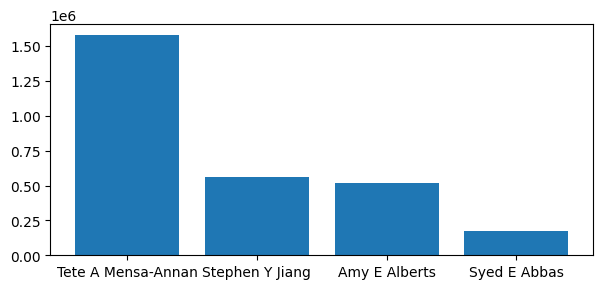

In [392]:
print(df_long3)
plt.figure(figsize=(7,3))
plt.bar(df_long3.FullName, df_long3.BetterThenLastYear)
plt.show()